# **实验作业-5：Clustering**
刘蔚璁 10225501443

## **任务**
1. 阅读人工数据集的构造方法，并自行提供一种与所提供的五种不同的人工数据集。<br>
    （每个点集均是一个二维数据集 $\{(x_{i,1},x_{i,2}),i=1,2,\cdots,n\}$）
2. 采用不同的聚类方式（包括：自下而上的层次聚类、Kmeans、GMM、DBSCAN），分别在六个数据集上进行聚类。
3. 请用绘图的方式展示不同聚类方式的结果。
4. 在不同数据集上，分别使用外部聚类有效性和内部聚类有效性的度量方法来比较不同聚类方法。请写明具体的外（内）部聚类有效性的度量方法，并将计算结果请填入下表（结论保留小数点后4位有效数字）。
    <table width = c(100,500,500), center = True>
        <tr>
            <td> 方法                  </td>
            <td> 外部有效性                 </td>
            <td> 内部有效性                 </td>
        </tr>
        <tr>
            <td> 层次聚类                 </td>
            <td>                  </td>
            <td>                  </td>
        </tr>
          <tr>
            <td> Kmean                 </td>
            <td>                  </td>
            <td>                  </td>
        </tr>
          <tr>
            <td> GMM                 </td>
            <td>                  </td>
            <td>                  </td>
        </tr>
          <tr>
            <td> DBSCAN                 </td>
            <td>                  </td>
            <td>                  </td>
        </tr>
    </table>

5. 通过本次实验，评述各类聚类方法的使用范围。

6. （选做）复现层次聚类、Kmeans、GMM、DBSCAN的代码。复现指的是通过理解原始代码的逻辑和功能，重新编写出一个具有相同功能的代码，只能使用最基础的包，如numpy、math等。

参考资料：https://scikit-learn.org/stable/modules/clustering.html#clustering

## **解决方案**

### **实验前的准备**

载入实验所需要的 Python 包：

In [519]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.linalg import eig
from collections import deque

# Cluster Method
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy

设置参数与随机种子：

In [374]:
np.random.seed(443)
n_samples = 1500 # sample size
n_subsets = [None] * 8

### **Task1.自行提供一种与所提供的五种不同的人工数据集**

#### **数据集-6：螺旋状数据集**

螺旋状数据集可以用来测试聚类算法在复杂、非球形簇上的表现，螺旋形簇具有连续性且方向明确，算法需要正确识别簇的连通性而不是简单地按距离聚类。

在该数据集中，我构造了两个螺旋形簇，每个螺旋的大小、旋转方向、旋转圈数有所不同，且有一小部分的重叠，用来测试算法是否能够基于数据拓扑结构进行分簇。

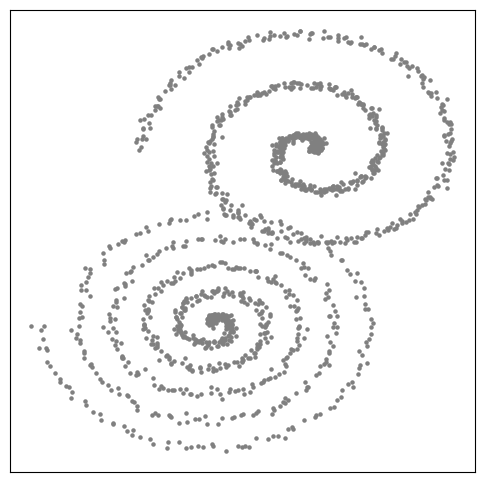

In [375]:
# 参数设置
K = 2    
n_subset = int(n_samples / K)
n_subsets[6] = K

x_spirals = []
offsets = [(17, 13), (-8, -8)]

for i in range(K):
    theta = np.linspace(0, np.pi * 5, n_subset) # 控制角度
    r = theta     
    theta = theta * (i+1)                       
   
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x += np.random.normal(scale=0.3, size=x.shape)
    y += np.random.normal(scale=0.3, size=y.shape)
    x += offsets[i][0]
    y += offsets[i][1]
    if i == 1:
        x = -x
    
    spiral = np.vstack((x, y)).T
    x_spirals.append(spiral)

dataset6 = np.vstack(x_spirals)

plt.figure(figsize=(6, 6))
plt.scatter(dataset6[:n_subset, 0], dataset6[:n_subset, 1], s=5, color="grey")
plt.scatter(dataset6[n_subset:, 0], dataset6[n_subset:, 1], s=5, color="grey")
plt.xticks(())
plt.yticks(())
plt.show()

接着计算簇内相关性和整体相关性，可以看到簇内相关性很低，整个数据集存在中等相关性：

In [376]:
cluster_1 = dataset6[:n_subset] 
cluster_2 = dataset6[n_subset:] 

correlation_cluster_1 = np.corrcoef(cluster_1[:, 0], cluster_1[:, 1])[0, 1]
correlation_cluster_2 = np.corrcoef(cluster_2[:, 0], cluster_2[:, 1])[0, 1]

print("簇 1 的 x 和 y 的相关性：", round(correlation_cluster_1,4))
print("簇 2 的 x 和 y 的相关性：", round(correlation_cluster_2,4))

correlation_dataset = np.corrcoef(dataset6[:, 0], dataset6[:, 1])[0, 1]
print("整个数据集 x 和 y 的相关性：", round(correlation_dataset,4))


簇 1 的 x 和 y 的相关性： -0.0946
簇 2 的 x 和 y 的相关性： 0.0504
整个数据集 x 和 y 的相关性： 0.4849


除此之外，我还构造了一个字母数据集：

#### **数据集-7：DaSE数据集**

字母数据集适合测试聚类算法的适应性，尤其是处理复杂形状的能力，因为字母结构复杂，包含直线、弧线、闭合区域等多样特征，这种多样性可以帮助测试算法的灵活性。

在该数据集中，我构造了包含“DaSE”四个字母的数据集。

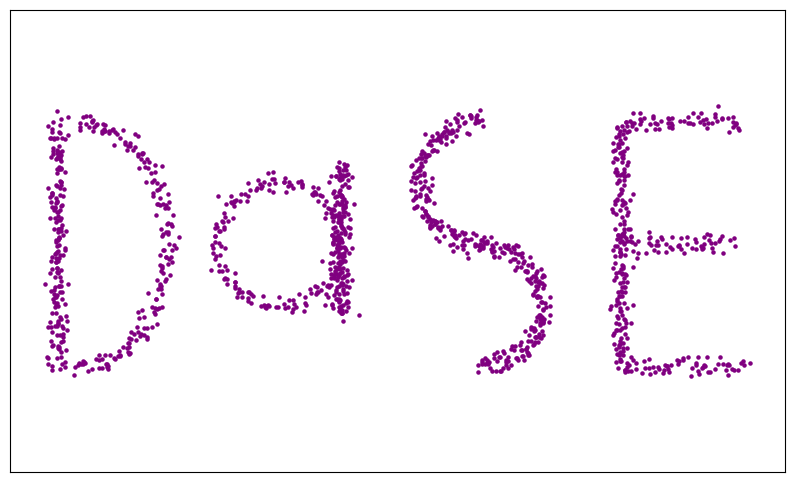

In [442]:
points_per_letter = int(n_samples / 4)
n_subsets[7] = 4
noise = 0.08

letter_spacing = 3.3  # 字母间距

# D
theta_d = np.linspace(-np.pi / 2, np.pi / 2, points_per_letter // 2)
x_d_outer = np.cos(theta_d) * 1.5 
y_d_outer = np.sin(theta_d) * 2.0
x_d_vert = np.ones(points_per_letter - (points_per_letter // 2)) * -0.3
y_d_vert = np.linspace(-2.0, 2.0, points_per_letter - (points_per_letter // 2))
x_d = np.concatenate([x_d_vert, x_d_outer])
y_d = np.concatenate([y_d_vert, y_d_outer])
x_d += 0 * letter_spacing

# a
theta_a = np.linspace(0, 2 * np.pi, points_per_letter // 2)
x_a_circle = np.cos(theta_a) * 1.0
y_a_circle = np.sin(theta_a) * 1.0
x_a_tail = np.linspace(1.0, 1.0, points_per_letter - (points_per_letter // 2))
y_a_tail = np.linspace(-1.0, -2.0, points_per_letter - (points_per_letter // 2))*2.5 + 3.8
x_a = np.concatenate([x_a_circle, x_a_tail])
y_a = np.concatenate([y_a_circle, y_a_tail])
x_a += 1 * letter_spacing

# S
theta_s1 = np.linspace(np.pi / 2, 3 * np.pi / 2, points_per_letter // 2)
x_s_top = np.cos(theta_s1) * 1.0
y_s_top = np.sin(theta_s1) * 1.0 + 1.0
theta_s2 = np.linspace(-np.pi / 2, np.pi / 2, points_per_letter - (points_per_letter // 2))
x_s_bottom = np.cos(theta_s2) * 1.0
y_s_bottom = np.sin(theta_s2) * 1.0 - 1.0
x_s = np.concatenate([x_s_top, x_s_bottom])
y_s = np.concatenate([y_s_top, y_s_bottom])
x_s += 2 * letter_spacing

# E
point_of_e_vert = points_per_letter // 2
point_left = points_per_letter - point_of_e_vert
point_lleft = point_left -  point_left // 3
point_lleft = point_lleft -  point_left // 3
x_e_vert = np.ones(point_of_e_vert) * -1.0
y_e_vert = np.linspace(-2.0, 2.0, point_of_e_vert)
x_e_top = np.linspace(-1.0, 1.0, point_left // 3)
y_e_top = np.ones(point_left // 3) * 2.0
x_e_mid = np.linspace(-1.0, 0.8, point_left // 3)
y_e_mid = np.zeros(point_left // 3)
x_e_bot = np.linspace(-1.0, 1.0, point_lleft)
y_e_bot = -np.ones(point_lleft) * 2.0
x_e = np.concatenate([x_e_vert, x_e_top, x_e_mid, x_e_bot])
y_e = np.concatenate([y_e_vert, y_e_top, y_e_mid, y_e_bot])
x_e += 3 * letter_spacing

x_all = np.concatenate([x_d, x_a, x_s, x_e])
y_all = np.concatenate([y_d, y_a, y_s, y_e])
x = x_all + np.random.normal(0, noise, x_all.shape)
y = y_all + np.random.normal(0, noise, y_all.shape)
dataset7 = np.vstack((x, y)).T

plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=5, color="purple")
plt.xticks(())
plt.yticks(())
plt.axis('equal')
plt.show()


接下来构造题目已给出的五种数据集：

#### **数据集-1：同方差同大小**

该数据集共有三个簇，每个簇包含相同数量的样本，且每个簇的数据从同一方差的正态分布中产生，因此各簇的扩散程度相同，仅中心位置不同。

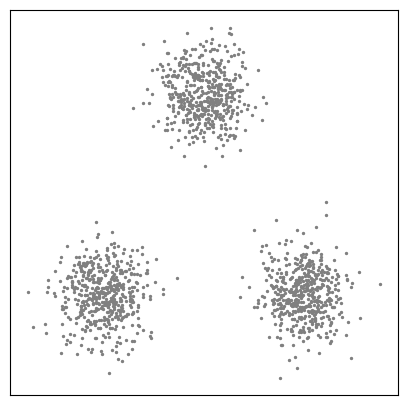

In [378]:
K = 3
n_subset = int(n_samples/K)
n_subsets[1] = K
# 生成三个簇
z1 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))
z2 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))
z3 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))

# 设置每个簇的中心坐标
mu1 = np.array([0,1])
mu2 = np.array([-math.sqrt(2),-math.sqrt(2)])
mu3 = np.array([math.sqrt(2),-math.sqrt(2)])

x11 = z1 + mu1
x12 = z2 + mu2
x13 = z3 + mu3
dataset1 = np.r_[x11,x12,x13]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x11[:,0],x11[:,1],color="grey",s = 2)
plt.scatter(x12[:,0],x12[:,1],color="grey",s = 2)
plt.scatter(x13[:,0],x13[:,1],color="grey",s = 2)


#### **数据集-2：高协方差**

该数据集共有三个簇，每个簇包含相同数量的样本，每个簇具有较高的协方差。
- 高协方差指的是两个变量之间具有较强的线性关系。具体来说，协方差衡量了两个变量如何共同变化。如果协方差的绝对值较大，说明两个变量之间的关系较强。

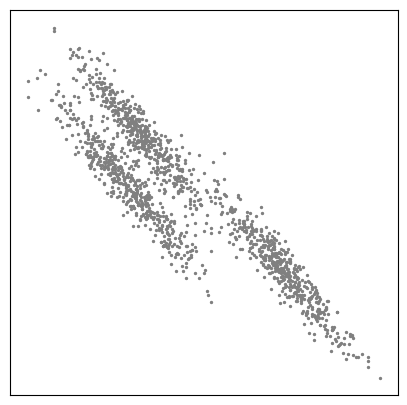

In [379]:
def mat_sqrt(Mat):
    eig_value,eig_vec = eig(Mat)
    return(eig_vec.dot(np.diag(np.sqrt(eig_value)).dot(eig_vec.T)))

K = 3
n_subset = int(n_samples/K)
n_subsets[2] = K
z1 = np.random.normal(loc = 0, scale = 1,size = (n_subset,2))
z2 = np.random.normal(loc = 0, scale = 1,size = (n_subset,2))
z3 = np.random.normal(loc = 0, scale = 1,size = (n_subset,2))

mu1 = np.array([-0.7,1])                
mu2 = np.array([-1,0.5])
mu3 = np.array([1.25,-0.5])
rho1 = -0.95                            # 协方差值
Sigma = np.array([[1,rho1],[rho1,1]])   # 协方差矩阵
sigma1 = 0.5                            # 缩放因子，控制数据的扩散程度

# 通过矩阵乘法将生成的标准正态分布数据 z1 乘上协方差矩阵的平方根，
# 并且通过 sigma1 缩放。这将会使数据的协方差结构符合 Sigma，即数据之间具有高相关性。
# 每个簇内的点的横纵坐标相关性较高，但不同簇之间的相关性没有直接定义。
x21 =  z1.dot(mat_sqrt(Sigma)*sigma1) + mu1
x22 = z2.dot(mat_sqrt(Sigma)*sigma1) + mu2
x23 = z3.dot(mat_sqrt(Sigma)*sigma1) + mu3
dataset2 = np.r_[x21,x22,x23]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x21[:,0],x21[:,1],color="grey",s = 2)
plt.scatter(x22[:,0],x22[:,1],color="grey",s = 2)
plt.scatter(x23[:,0],x23[:,1],color="grey",s = 2)

#### **数据集-3：方差不同 && 大小不同**

该数据集中共有 3 个簇，它们包含不同的样本量和方差，其中簇 2 最分散，簇 1 最紧密。

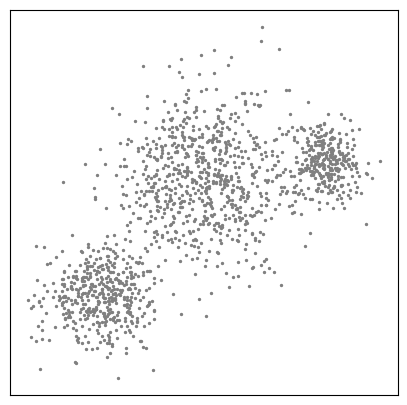

In [380]:
mu1 = np.array([1.5,0.5])
mu2 = np.array([0.2,0.3])
mu3 = np.array([-1,-1])
sigma = 0.1
sigma1 = 2*sigma
sigma2 = 5*sigma    # 簇 2 最分散
sigma3 = 3*sigma
n_subset1 = int(sigma1/(sigma1+sigma2+sigma3)*n_samples)  # 20%
n_subset2 = int(sigma2/(sigma1+sigma2+sigma3)*n_samples)  # 50%
n_subset3 = int(sigma3/(sigma1+sigma2+sigma3)*n_samples)  # 30%
n_subsets[3] = 3

x31 = np.random.normal(loc = 0, scale = sigma1,size = (n_subset1,2)) + mu1
x32 = np.random.normal(loc = 0, scale = sigma2,size = (n_subset2,2)) + mu2
x33 = np.random.normal(loc = 0, scale = sigma3,size = (n_subset3,2)) + mu3

dataset3 = np.r_[x31,x32,x33]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x31[:,0],x31[:,1],color="grey",s = 2)
plt.scatter(x32[:,0],x32[:,1],color="grey",s = 2)
plt.scatter(x33[:,0],x33[:,1],color="grey",s = 2)

#### **数据集-4：环形数据集**

该数据集包含两个簇，两个簇呈同心环状，二者半径不同。

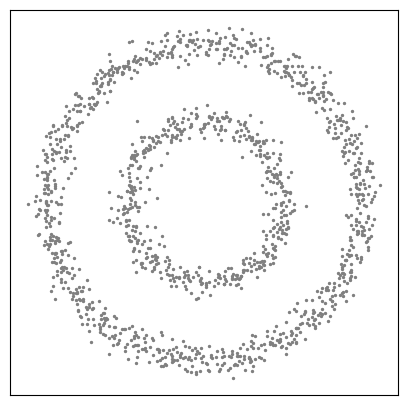

In [381]:
r1 = 1
r2 = 2

K = r1+r2
n_subset1 = int(n_samples/K)
n_subset2 = int(n_samples/K*(K-1))
n_subsets[4] = 2

# 环的角度序列，分别对应每个环的数据点在圆周上的分布。
theta1 = np.linspace(1,360,n_subset1)/360*2*math.pi
theta2 = np.linspace(1,360,n_subset2)/360*2*math.pi
# 生成噪声数据，用于在环形坐标的基础上添加扰动，使得数据更自然、不完全规则。
z1 = np.random.normal(loc = 0, scale = 0.1,size = (n_subset1,2))
z2 = np.random.normal(loc = 0, scale = 0.1,size = (n_subset2,2))

x41 = np.transpose(np.array([[r1 * math.cos(theta1[i]) for i in range(len(theta1))],
               [r1 * math.sin(theta1[i]) for i in range(len(theta1))]])) + z1
x42 = np.transpose(np.array([[r2 * math.cos(theta2[i]) for i in range(len(theta2))],
               [r2 * math.sin(theta2[i]) for i in range(len(theta2))]])) + z2
dataset4 = np.r_[x41,x42]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x41[:,0],x41[:,1],color="grey",s = 2)
plt.scatter(x42[:,0],x42[:,1],color="grey",s = 2)

#### **数据集-5：波浪形数据集**

该数据集包含两个簇，这两个簇呈现中心对称的波浪状分布。

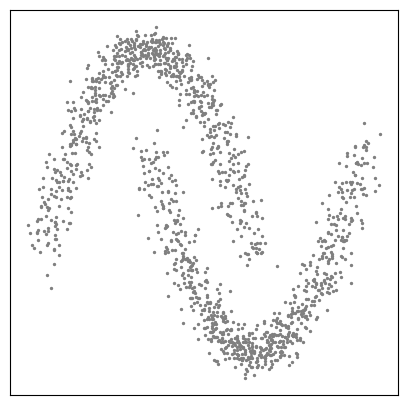

In [382]:
## Case Five : Wave Plot

a = 1/(-1.2+0.5)**2 # 缩放系数，用来控制波浪曲线的幅度
n_subset=int(n_samples/2)
n_subsets[5] = 2

x = np.linspace(-1.5,0.5,n_subset)  # 在区间 [-1.5, 0.5] 上均匀生成的 n_subset 个点
y1 = (-a)*(x+0.5)**2 + 1.5
y2 = (a)*(-x -0.5)**2 - 1.5
z1 = np.random.normal(loc = 0, scale = 0.1,size = (n_subset,2))
z2 = np.random.normal(loc = 0, scale = 0.1,size = (n_subset,2))

x51 = np.c_[x,y1] + z1
x52 = np.c_[-x,y2] + z2
dataset5 = np.r_[x51,x52]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x51[:,0],x51[:,1],color="grey",s = 2)
plt.scatter(x52[:,0],x52[:,1],color="grey",s = 2)


### **Task2&3.使用四种聚类方法进行聚类并可视化聚类结果**
- 自下而上的层次聚类、Kmeans、GMM、DBSCAN

In [392]:
def clustering_with_4(K,dataset,params,plt_title,ds_labels):
    methods = {
    "Hierarchical (Agglomerative)": AgglomerativeClustering(n_clusters=K),
    "KMeans": KMeans(n_clusters=K),
    "GMM": GaussianMixture(n_components=K),
    "DBSCAN": DBSCAN(eps=params[0], min_samples=params[1])
    }

    ds1_labels = []
    plt.figure(figsize=(12, 10))

    for i, (name, method) in enumerate(methods.items(), 1):
        labels = method.fit_predict(dataset)
        ds_labels.append(labels)

        plt.subplot(2, 2, i)
        plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, s=5, cmap='viridis')
        plt.title(name)
        plt.xticks(())
        plt.yticks(())

    plt.suptitle(plt_title)
    plt.show()


#### **Dataset-1**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


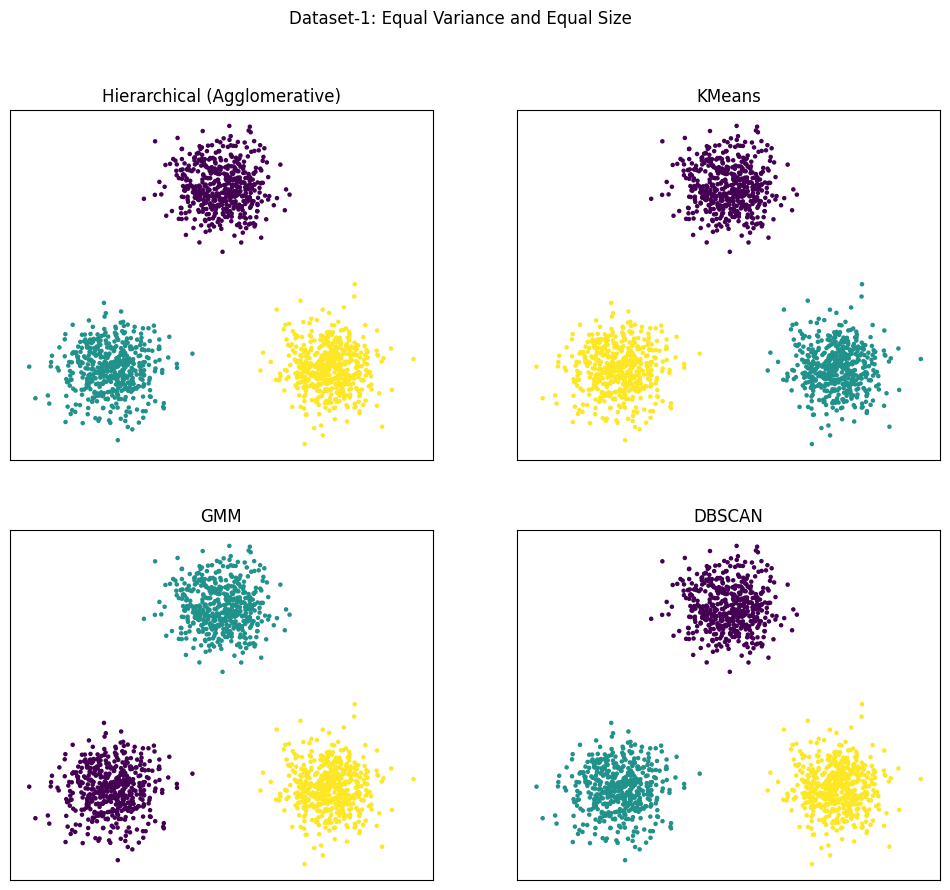

In [393]:
params = [0.5,4]
title = "Dataset-1: Equal Variance and Equal Size"
ds1_labels = []
clustering_with_4(n_subsets[1],dataset1,params,title,ds1_labels)

#### **Dataset-2**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


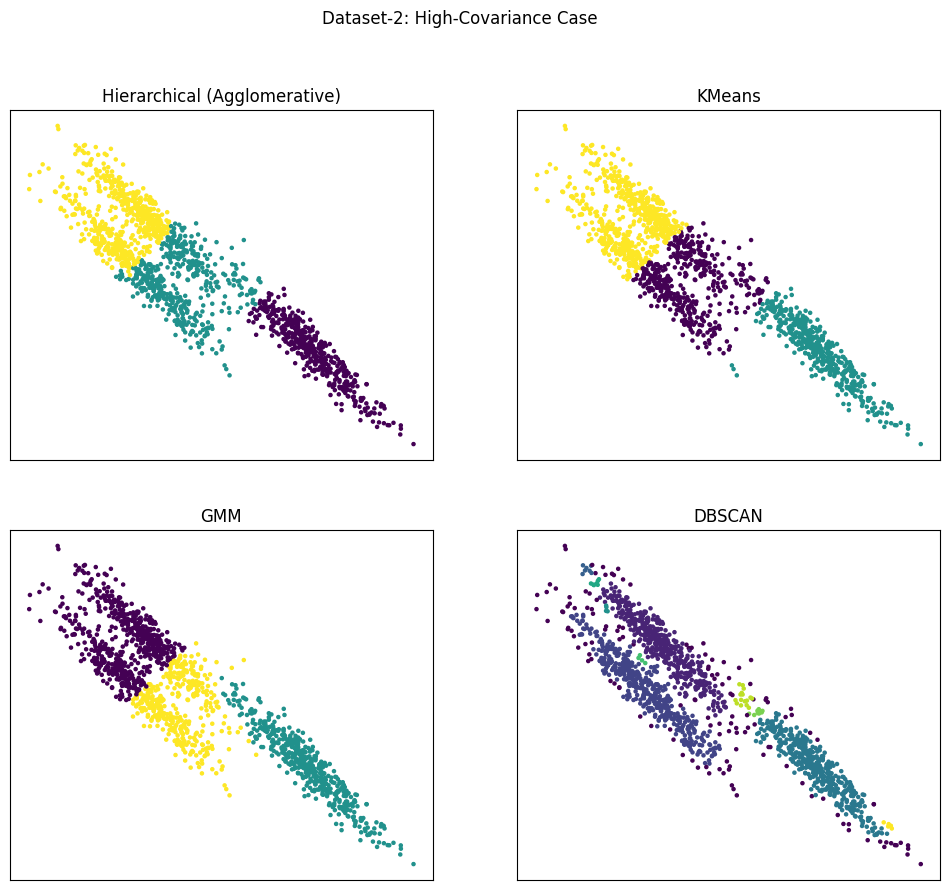

In [446]:
ds2_labels = []
params = [0.08,5]
title = "Dataset-2: High-Covariance Case"
clustering_with_4(n_subsets[2],dataset2,params,title,ds2_labels)

#### **Dataset-3**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


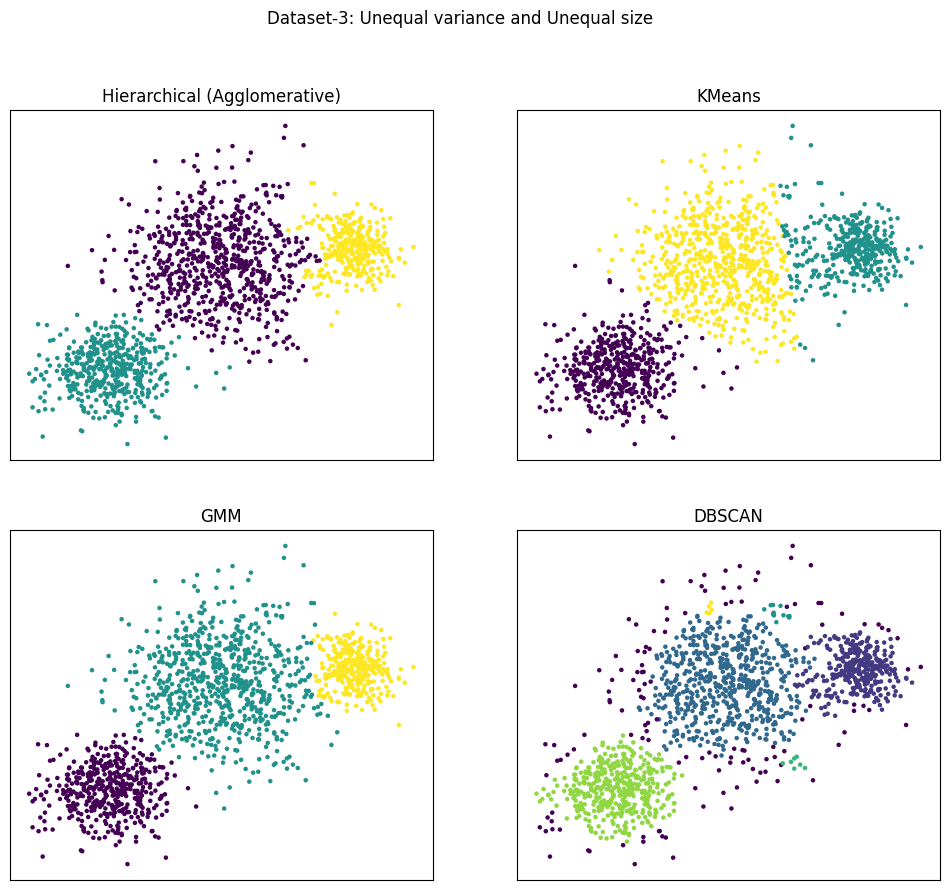

In [395]:
ds3_labels = []
params = [0.1,5]
title = "Dataset-3: Unequal variance and Unequal size"
clustering_with_4(n_subsets[3],dataset3,params,title,ds3_labels)

#### **Dataset-4**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


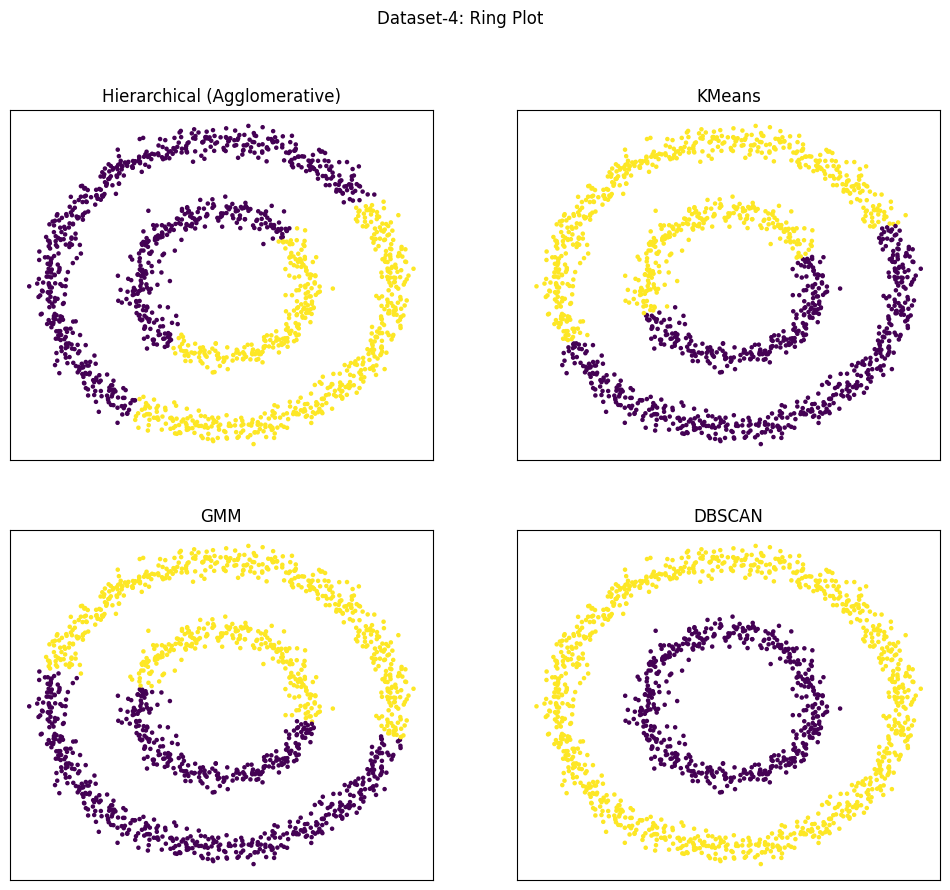

In [396]:
ds4_labels = []
params = [0.3,6]
title = "Dataset-4: Ring Plot"
clustering_with_4(n_subsets[4],dataset4,params,title,ds4_labels)

#### **Dataset-5**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


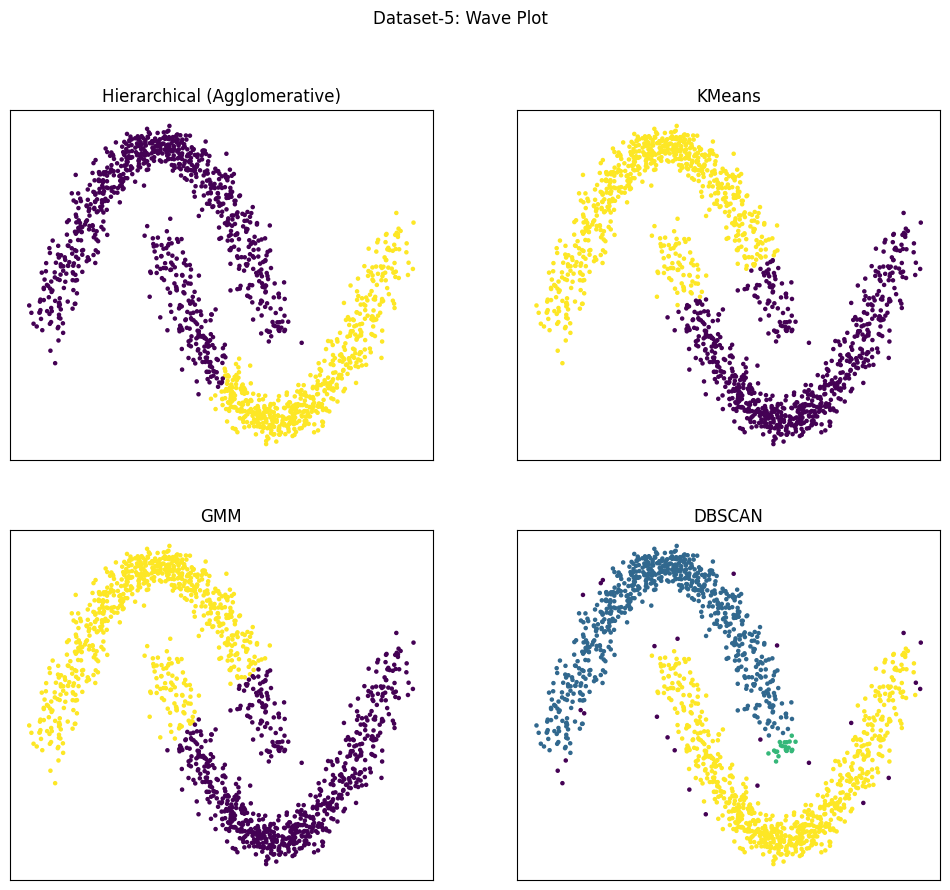

In [397]:
ds5_labels = []
params = [0.1,5]
title = "Dataset-5: Wave Plot"
clustering_with_4(n_subsets[5],dataset5,params,title,ds5_labels)

#### **Dataset-6**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


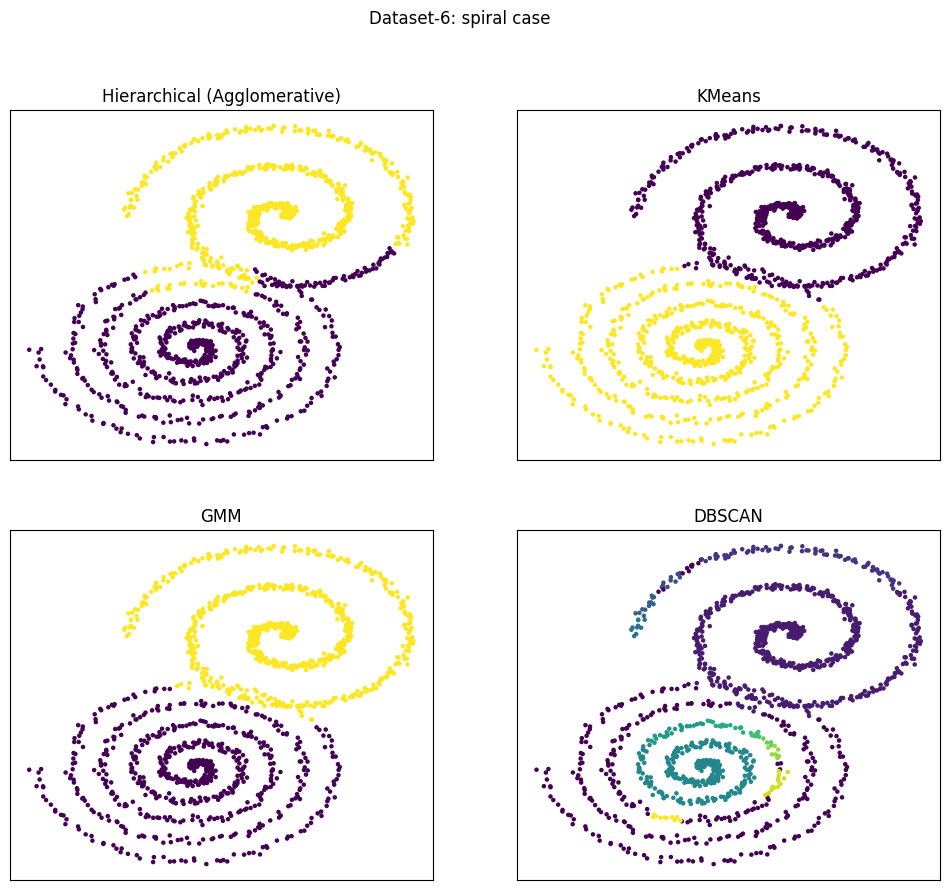

In [398]:
ds6_labels = []
params = [1.5,10]
title = "Dataset-6: spiral case"
clustering_with_4(n_subsets[6],dataset6,params,title,ds6_labels)

#### **Dataset-7**

d:\Python\envs\iueio\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


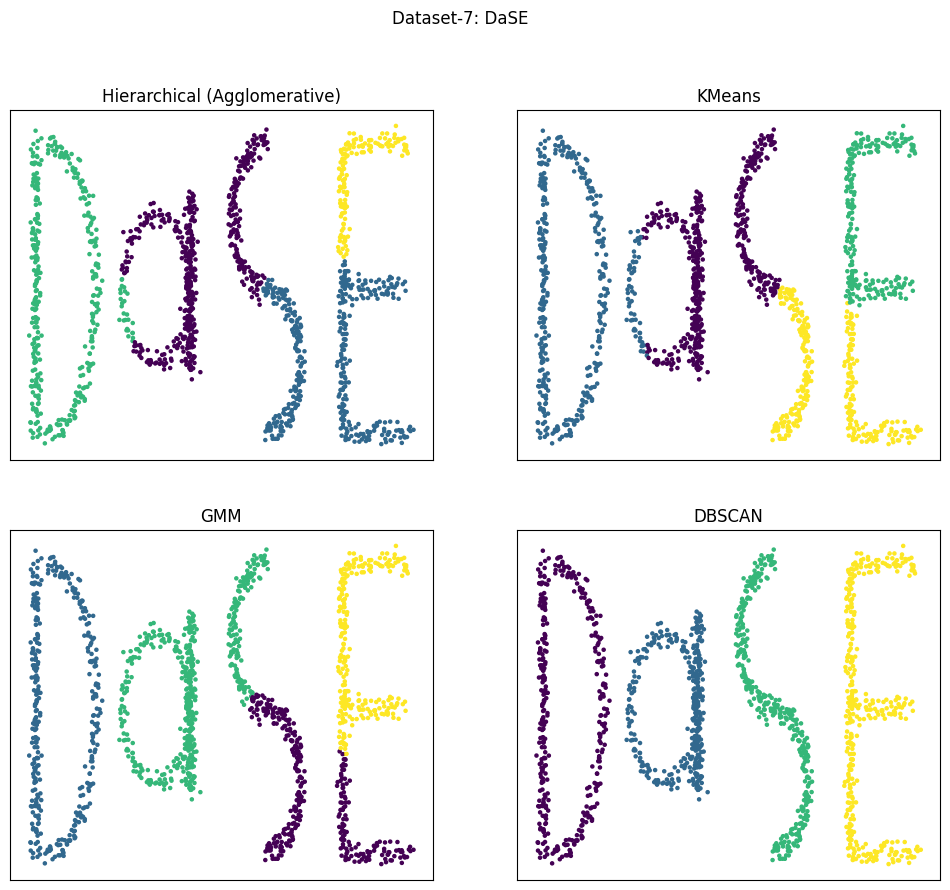

In [443]:
ds7_labels = []
params = [0.3,5]
title = "Dataset-7: DaSE"
clustering_with_4(n_subsets[7],dataset7,params,title,ds7_labels)

### **Task4.在不同数据集上，分别使用外部聚类有效性和内部聚类有效性的度量方法来比较不同聚类方法。**

**内外部聚类有效性的区别**：是否使用外部的信息来评价聚类的有效性。

- #### **外部聚类有效性**
    对于 $n$ 个测试样本 $x_i$ $(i = 1, 2, \cdots, n)$：

    - 假定分类结果为 $\mathcal{C} = \{\mathbf{C}_1, \mathbf{C}_2, \cdots, \mathbf{C}_K\}$ 并满足：
    $$
    \mathbf{C}_k \cap \mathbf{C}_l = \emptyset, \quad \bigcup_{k=1}^K \mathbf{C}_k = X
    $$
    - $K$ 为聚类数目；

    - 假设“真实的”标签划分 $\mathcal{Y} = \{\mathbf{Y}_1, \mathbf{Y}_2, \cdots, \mathbf{Y}_{K'}\}$ 并满足：
    $$
    \mathbf{Y}_k \cap \mathbf{Y}_l = \emptyset, \quad \bigcup_{k=1}^{K'} \mathbf{Y}_k = X
    $$
    - $K'$ 为真实分类数目；

    - 可能性矩阵（Contingency Matrix）定义为
        $$
        \begin{array}{c|cccc|c}
            & \mathbf{Y}_1 & \mathbf{Y}_2 & \cdots & \mathbf{Y}_{K'} & \text{求和} \\
            \hline
            \mathbf{C}_1 & n_{11} & n_{12} & \cdots & n_{1K'} & n_{1 \cdot} \\
            \mathbf{C}_2 & n_{21} & n_{22} & \cdots & n_{2K'} & n_{2 \cdot} \\
            \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
            \mathbf{C}_K & n_{K1} & n_{K2} & \cdots & n_{K K'} & n_{K \cdot} \\
            \hline
            \text{求和} & n_{\cdot 1} & n_{\cdot 2} & \cdots & n_{\cdot K'} & n \\
        \end{array}
        $$

    - 我们可以计算
        $$
        p_{ij} = \frac{n_{ij}}{n}, \quad p_i = \frac{n_{i \cdot}}{n}, \quad p_j = \frac{n_{\cdot j}}{n}
        $$

    熵和纯度是两种常用的外部度量：
    - **熵**

        熵度量了聚类中类别的混乱程度。对于每个簇，熵值越高，表示该簇中包含了更多不同的真实类别，聚类的纯度越低；熵值越低，表示该簇中同一类别的数据点越多，聚类的纯度越高。
        
        表达式如下：
        $$E = - \sum_{i} p_i \left( \sum_{j} \frac{p_{ij}}{p_i} \ln \frac{p_{ij}}{p_i} \right)$$
        取值范围：熵值越接近 0，聚类结果越纯；熵值越高，聚类结果越混乱。
    - **纯度**

        纯度衡量了聚类结果与真实标签的匹配程度，是一种简单的外部度量指标。纯度越高，表示簇中的数据点大多属于同一真实类别，聚类效果越好。

        表达式如下：
        $$P = \sum_{i} p_i \left( \max_{j} \frac{p_{ij}}{p_i} \right)$$
        取值范围：0 到 1 之间，纯度值越接近 1，表示聚类效果越好。

在本题中，我们使用熵来作为外部聚类有效性的度量，编写计算熵的函数：

In [ ]:
methods_list = ["Hierarchical (Agglomerative)","KMeans","GMM","DBSCAN"]

def get_Entropy(ds_labels, cluster_sizes):
    true_labels = np.concatenate([np.repeat(i, size) for i, size in enumerate(cluster_sizes)])

    entropies = {}

    for idx in range(4):
        # 可能性矩阵
        contingency_matrix = confusion_matrix(true_labels, ds_labels[idx])
        
        total_entropy = 0
        for i in range(contingency_matrix.shape[0]):
            row = contingency_matrix[i]
            row_sum = np.sum(row)   # n_i.
            if row_sum == 0:
                continue
            row_entropy = entropy(row / row_sum)  # 信息熵
            total_entropy += (row_sum / n_samples) * row_entropy  # 总体熵/加权平均熵
        
        entropies[methods_list[idx]] = round(total_entropy,4)

    for method, ent in entropies.items():
        print(f"{method} 的熵: {ent}")

- #### **内部聚类有效性**
  内部聚类有效性的两个准则：
  
  - **紧密度（Compactness）** <br>
    在同一类内不同个体之间相似程度的度量。
    - 方差可以体现数据的紧密度；低方差表明数据差异小，则紧密度好；
    - 很多紧密度的定义是依赖于距离的，如：最大或平均类内两距离，基于中心的最大或平均距离，等。
    
  - **区分度（Separation）**<br>
    不同类间差异程度的度量。
    - 例如，两个类中心的距离，或从两个不同类中任各选择一个体的最短距离，通常作为区分度的度量；
    - 密度（density）也会用于度量区分度。

  **常用指标：**

  - **均方标准差**

    衡量聚类结果内部紧密度的一种指标，用来评估每个簇内数据点离簇中心的平均偏离程度。均方标准差越小，说明簇内数据点越接近簇中心，聚类结果的紧密度越好。

    $$
    \left( \frac{\sum_{k=1}^K \sum_{i \in C_k} \|x_i - m_k\|_2^2}{p \sum_{k=1}^K (n_k - 1)} \right)^{1/2}
    $$

    其中：
    - $ K $：聚类的簇数。
    - $ C_k $：第 $ k $ 个簇的集合。
    - $ x_i $：第 $ k $ 个簇中的第 $ i $ 个数据点。
    - $ m_k $：第 $ k $ 个簇的质心（簇中心）。
    - $ n_k $：第 $ k $ 个簇中的数据点数量。
    - $ p $：数据的维度。
    - $ \| x_i - m_k \|^2 $：数据点 $ x_i $ 到簇中心 $ m_k $ 的欧氏距离的平方。

  - **$ R^2 $**
  
    $R^2$ 表示聚类结果的解释力，衡量的是类间方差与总方差的比例，可以理解为聚类划分对数据分布的解释程度。简单来说，$R^2$ 越大，说明聚类结果越好，类内样本越集中、类间样本越分散。
    $$
    1 - \frac{\sum_{k=1}^K \sum_{i \in C_k} \|x_i - m_k\|_2^2}{\sum_{i=1}^n \|x_i - \bar{x}\|_2^2}
    $$

    其中：
    - $ x_i $ 是数据集中第 $ i $ 个数据点。
    - $ m_k $ 是第 $ k $ 个簇的质心。
    - $ \bar{x} $ 是整个数据集的均值。
    - $ \| x_i - m_k \|^2 $ 表示点 $ x_i $ 到簇中心 $ m_k $ 的距离平方。
    - $ \| x_i - \bar{x} \|^2 $ 表示点 $ x_i $ 到数据集均值的距离平方。

  
  除此之外，还可以使用轮廓系数、Dunn 指数、CH指数等来度量内部聚类有效性。


在本题中，我们使用决定系数 $R^2$ 来作为外部聚类有效性的度量，编写计算 $R^2$ 的函数：

In [449]:
def calculate_R2(dataset, ds_labels):
    R2s = {}

    for idx in range(4):

        # 总方差
        overall_mean = np.mean(dataset, axis=0) 
        total_variance = np.sum(np.linalg.norm(dataset - overall_mean, axis=1) ** 2)
        
        # 类内方差
        within_cluster_variance = 0.0
        unique_labels = np.unique(ds_labels[idx])# 簇标识
        for label in unique_labels:
            cluster_points = dataset[ds_labels[idx] == label]
            
            cluster_mean = np.mean(cluster_points, axis=0)
            within_cluster_variance += np.sum(np.linalg.norm(cluster_points - cluster_mean, axis=1) ** 2)

        R2 = 1 - (within_cluster_variance / total_variance)
        R2s[methods_list[idx]] = round(R2,4)
    
    for method, r in R2s.items():
        print(f"{method} 的决定系数: {r}")

#### **Dataset-1：**

In [ ]:
cluster_sizes = [int(n_samples/3),int(n_samples/3),int(n_samples/3)]
get_Entropy(ds1_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.0
KMeans 的熵: 0.0
GMM 的熵: 0.0
DBSCAN 的熵: 0.0


In [450]:
calculate_R2(dataset1,ds1_labels)

Hierarchical (Agglomerative) 的决定系数: 0.9344
KMeans 的决定系数: 0.9344
GMM 的决定系数: 0.9344
DBSCAN 的决定系数: 0.9344


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.0         </td>
        <td>           0.9344       </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.0          </td>
        <td>           0.9344           </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.0             </td>
        <td>          0.9344            </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.0             </td>
        <td>          0.9344            </td>
    </tr>
</table>

该数据集分为四个明显的簇，每个簇之间具有清晰的分界，且每个簇的样本数量和分布方差都相等。

在这个数据集中，四种聚类方法在外部有效性（熵）上都为 0.0，说明它们都能完美地分辨出不同类别，且在该数据集上取得了相同的分类效果。内部有效性（决定系数）为 0.9344，表明四种方法在类内紧密度和类间分离度方面表现一致，达到了较高的聚类效果。

#### **Dataset-2：**

In [ ]:
cluster_sizes = [int(n_samples/3),int(n_samples/3),int(n_samples/3)]
get_Entropy(ds2_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.5608
KMeans 的熵: 0.5683
GMM 的熵: 0.4814
DBSCAN 的熵: 0.5279


In [451]:
calculate_R2(dataset2,ds2_labels)

Hierarchical (Agglomerative) 的决定系数: 0.8478
KMeans 的决定系数: 0.8485
GMM 的决定系数: 0.8351
DBSCAN 的决定系数: 0.7175


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.5608         </td>
        <td>           0.8478       </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.5683          </td>
        <td>           0.8485           </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.4814             </td>
        <td>          0.8351            </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.5279             </td>
        <td>          0.7175            </td>
    </tr>
</table>

这个数据集的簇之间具有较高的协方差，导致簇的形状拉长，呈现出倾斜的分布，且簇之间的重叠度比均等方差的情况更高，导致不同簇之间的分界变得模糊，增加了聚类的难度。

- 在此数据集上，GMM 的熵值低，且决定系数接近最佳。
- 层次聚类和 Kmean 的两组数据接近，熵值偏高，但决定系数接近最佳。
- DBSCAN 具有较高的熵值和较低的决定系数，说明其纯度较低，且它适合处理稀疏且形状不规则的分布，而该数据集中簇结构相对密集且倾斜，导致边缘难以准确分割。
- 但是从可视化结果来看，DBSCAN 的聚类最符合实际的分割情况

#### **Dataset-3：**

In [ ]:
cluster_sizes = [int(n_samples*0.2), int(n_samples*0.5), int(n_samples*0.3)]
get_Entropy(ds3_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.1662
KMeans 的熵: 0.2458
GMM 的熵: 0.1385
DBSCAN 的熵: 0.5181


In [452]:
calculate_R2(dataset3,ds3_labels)

Hierarchical (Agglomerative) 的决定系数: 0.8056
KMeans 的决定系数: 0.8147
GMM 的决定系数: 0.7986
DBSCAN 的决定系数: 0.7588


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.1662         </td>
        <td>           0.8056       </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.2458          </td>
        <td>           0.8147           </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.1385             </td>
        <td>          0.7986            </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.5181             </td>
        <td>          0.7588            </td>
    </tr>
</table>

该数据集数据分布呈现出不均匀的结构，不同簇之间的密度和形状有较大差异，导致聚类边界模糊且簇结构不均匀。

在这种不均匀密度的数据集中：
- 层次聚类和 GMM 在此数据集上都取得了低熵值，并能较好地捕捉簇的结构。
- KMeans在该数据集上效果一般，因为其更适合相似大小和密度的簇，这在该数据集中可能导致部分簇的分割不够清晰。
- DBSCAN在该数据集上表现最差，因为其对密集度依赖较强，导致无法准确分离密度差异大的簇。

#### **Dataset-4：**

In [ ]:
cluster_sizes = [int(n_samples/3), int(n_samples/3*(3-1))]
get_Entropy(ds4_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.6856
KMeans 的熵: 0.6931
GMM 的熵: 0.693
DBSCAN 的熵: 0.0


In [453]:
calculate_R2(dataset4,ds4_labels)

Hierarchical (Agglomerative) 的决定系数: 0.3658
KMeans 的决定系数: 0.3773
GMM 的决定系数: 0.3764
DBSCAN 的决定系数: 0.0


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.6856         </td>
        <td>           0.3658       </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.6931          </td>
        <td>           0.3773           </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.6930             </td>
        <td>          0.3764            </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.0             </td>
        <td>          0.0           </td>
    </tr>
</table>

该数据集由两个圆环形状的簇组成。由于数据集中存在非线性分离的特性，两个簇之间的分隔不规则且相对复杂。

- DBSCAN 在该数据集上表现最佳，因为它可以通过密度进行聚类，不需要簇形状的线性假设，非常适合该数据集。
- 其它三个数据集都不能很好地处理该数据集
    - 层次聚类无法很好地处理环状数据，因为它在聚合过程中受到距离度量的限制。
    - KMeans假设簇是球形且等方差的，因此对环状数据表现较差。它无法分开两个圆环形的簇，反而将其划分为线性分布的簇。
    - GMM假设数据服从高斯分布，因此在环形数据上无法有效聚类。它尝试将每个簇分配为高斯分布，但在环形结构中表现不佳。

#### **Dataset-5：**

In [ ]:
cluster_sizes = [int(n_samples/2), int(n_samples/2)]
get_Entropy(ds5_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.2815
KMeans 的熵: 0.3161
GMM 的熵: 0.3533
DBSCAN 的熵: 0.1537


In [454]:
calculate_R2(dataset5,ds5_labels)

Hierarchical (Agglomerative) 的决定系数: 0.5599
KMeans 的决定系数: 0.6482
GMM 的决定系数: 0.6466
DBSCAN 的决定系数: 0.5834


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.2815         </td>
        <td>           0.5599      </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.3161         </td>
        <td>           0.6482          </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.3533            </td>
        <td>          0.6466           </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.1537            </td>
        <td>          0.5834           </td>
    </tr>
</table>

该数据集具有明显的“波浪形”结构，属于非线性分布的数据类型。数据点分布在两条不同的弧线上，中间有较大的分隔。

- 表现最佳的仍然是 DBSCAN，它能识别波浪形结构中的点簇，不受球形和高斯分布假设的限制。因此，在该非线性结构中能更好地分开两个簇，但内部紧密度略低。
- 层次聚类在非线性数据结构上的表现稍差，特别是在处理这种波浪形分布时，容易产生较多误分类。
- KMeans假设球形簇，因此在波浪形数据上难以准确聚类。虽然 $R^2$ 较高，表明聚类内紧密度好，但纯度低，说明其对簇的分离效果差，部分数据点被错误归类。
- GMM假设数据点服从高斯分布，因此对波浪形的分布不适应，结果与KMeans相似。其在非线性簇结构上表现较差。

#### **Dataset-6：**

In [ ]:
cluster_sizes = [int(n_samples/2),int(n_samples/2)]
get_Entropy(ds6_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.264
KMeans 的熵: 0.0818
GMM 的熵: 0.0818
DBSCAN 的熵: 0.9658


In [455]:
calculate_R2(dataset6,ds6_labels)

Hierarchical (Agglomerative) 的决定系数: 0.6004
KMeans 的决定系数: 0.6471
GMM 的决定系数: 0.6471
DBSCAN 的决定系数: 0.6981


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.2640       </td>
        <td>           0.6004    </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.0818        </td>
        <td>           0.6471          </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.0818          </td>
        <td>          0.6471           </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.9658           </td>
        <td>          0.6981          </td>
    </tr>
</table>

该数据集为螺旋状结构，属于复杂的非线性分布类型，数据分布在两个紧密缠绕的螺旋中，属于极难分割的形状。

- DBSCAN可以有效识别出螺旋形的簇结构，因为它对非线性和形状的假设更少。在这种螺旋数据中，DBSCAN能够将每个螺旋分配给不同的簇，表现最佳。
- 层次聚类在螺旋结构数据上表现不如DBSCAN，但相比KMeans和GMM，其能够更好地处理非球形结构的数据。
- KMeans假设球形簇，因此在这种螺旋形结构上难以分离正确的簇结构。它将数据点分为两个线性分布的簇，这与实际螺旋结构不符。
- GMM在螺旋形数据上表现不佳，因为它假设数据点服从高斯分布，不适用于复杂的螺旋形结构。

*ps.*

从图中可以看到，DBSCAN 依然将螺旋形簇分成了多个小的子簇，这表明连通性不理想，可能的原因有：
- 螺旋形数据集本身是一种复杂的非线性结构，各点的密度可能变化较大（例如，内圈通常密度较高，外圈密度较低）。在这种结构中，DBSCAN 很难沿着螺旋路径保持连通，因为螺旋中部和边缘的点距离分布差异较大，容易被误判为噪声或其他小簇。

#### **Dataset-7：**

In [445]:
cluster_sizes = [int(n_samples/4),int(n_samples/4),int(n_samples/4),int(n_samples/4)]

get_Entropy(ds7_labels,cluster_sizes)

Hierarchical (Agglomerative) 的熵: 0.4015
KMeans 的熵: 0.4468
GMM 的熵: 0.3309
DBSCAN 的熵: 0.0


In [456]:
calculate_R2(dataset7,ds7_labels)

Hierarchical (Agglomerative) 的决定系数: 0.8498
KMeans 的决定系数: 0.8573
GMM 的决定系数: 0.8521
DBSCAN 的决定系数: 0.8544


<table width = c(100,500,500), center = True>
    <tr>
        <td> 方法                  </td>
        <td> 外部有效性                 </td>
        <td> 内部有效性                 </td>
    </tr>
    <tr>
        <td> 层次聚类                 </td>
        <td>         0.4015      </td>
        <td>           0.8498     </td>
    </tr>
        <tr>
        <td> Kmean                 </td>
        <td>        0.4468        </td>
        <td>           0.8573          </td>
    </tr>
        <tr>
        <td> GMM                 </td>
        <td>     0.3309            </td>
        <td>          0.8521          </td>
    </tr>
        <tr>
        <td> DBSCAN                 </td>
        <td>     0.0           </td>
        <td>          0.8544        </td>
    </tr>
</table>

该数据集具有字母结构，点的分布形成了清晰的字符形状，每个字符具有分离的结构，但不是简单的球状或线性形状。

- DBSCAN表现最佳，因为它能够有效地识别字符结构中的稀疏和密集区域，将字母之间的点准确分离。其对形状的灵活处理能力使其特别适合该数据集。
- 其它三种方法能够分离出部分结构（笔画），但是对于字母的分离效果一般。

### **Task5.评述各类聚类方法的使用范围**

#### **层次聚类**
层次聚类可以分为自下而上和自上而下两种策略，其核心是根据样本间的相似性构建层次结构。这种方法在处理复杂簇结构和层级关系上表现优异。

**适用范围**
- 适用于不同大小和密度的簇，能够有效地处理复杂形状的簇，如密度变化较大或大小不均的簇。
- 在有明确层次结构或希望分析簇的层级关系时尤为有效。
  
**优缺点**
- **优点**：对初始簇数无要求，可以自适应地生成从较粗到较细的层次划分。适合处理复杂簇结构，尤其是在数据呈现多层次关系时表现优异。
- **缺点**：计算复杂度较高，数据量较大时计算效率低，且对噪声敏感。适用于簇数量较少、数据量较小的情况。

**典型使用场景**
- 生物学、生态学等领域，用于构建进化树等层次结构。
- 数据中存在不同密度、形状复杂的簇，且希望挖掘簇的层级关系。

#### **KMeans**
KMeans 是一种基于均值的聚类算法，假设每个簇的形状接近于球形，因此更适合处理相对规则和均匀分布的簇。

**适用范围**
- 适用于簇形状为球形、大小和密度相似的数据集，常用于处理具有对称结构的数据。

**优缺点**
- **优点**：算法简单高效，易于实现。对大数据集效率较高，适合在簇结构简单的场景中使用。
- **缺点**：依赖初始中心点选择，容易陷入局部最优；对于非球形簇或大小、密度差异明显的簇效果较差。对簇的数量敏感，需要提前确定簇数。

**典型使用场景**
- 图像分割、客户细分等需要简单高效聚类的任务。
- 适合用于处理较为规则的簇结构（如标准化或均匀分布的点）。

### **高斯混合模型**
GMM 采用概率模型的方式，将每个簇视为高斯分布的混合体，能够更好地处理数据集中不同方向的协方差特性。

**适用范围**
- 适用于具有高协方差的非球形簇、不同大小和密度的簇，能够较好地拟合倾斜或重叠的簇。
- 对高协方差或复杂形状的簇有更强的适应性。

**优缺点**
- **优点**：能够适应不同的簇形状（特别是椭圆形和倾斜分布），分配给每个点一个概率，能够处理簇的重叠问题。对密度和形状的变化适应性较强。
- **缺点**：计算复杂度较高，对参数敏感。训练时间较长，尤其是在高维空间中性能较差。

**典型使用场景**
- 用于复杂数据的聚类，特别是在簇的形状和密度不规则时表现较好。
- 数据中存在重叠或连续的簇结构（如金融市场数据、图像分析等），适合使用 GMM 建模。

#### **DBSCAN**
DBSCAN 通过密度来定义簇的边界，适合用于具有离群点的稀疏数据，且能够识别任意形状的簇。

**适用范围**
- 适用于任意形状的簇，尤其在稀疏数据、具有离群点或非均匀密度分布的数据中效果较好。
- 对离群点有很好的处理能力，但**对不同密度的簇不敏感**。

**优缺点**
- **优点**：能够识别任意形状的簇，对噪声数据和离群点有很强的鲁棒性；不需要指定簇的数量。
- **缺点**：对参数敏感，特别是对邻域半径和最小样本数的设置依赖较大；对密度变化大的数据集表现较差。
  
**典型使用场景**
- 用于处理具有离群点、密度变化较大的地理空间数据或其他具有不规则形状的数据集。
- 比如检测异常值、空间数据分析，或在稀疏数据中发现独立簇结构。

### **Task6.复现层次聚类、Kmeans、GMM、DBSCAN的代码**
- 只能使用最基础的包，如numpy、math等
- 本题使用以下构造的数据集进行复现的展示

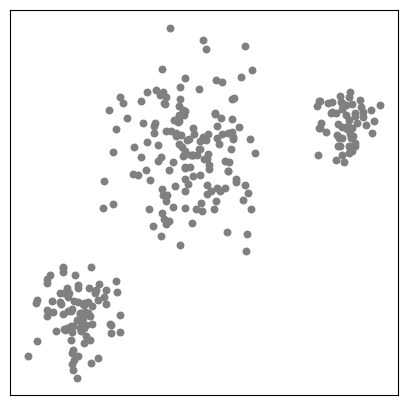

In [479]:
n_samples_small = 300
mu1 = np.array([1.5,0.5])
mu2 = np.array([0.2,0.3])
mu3 = np.array([-0.8,-0.8])
sigma = 0.06
sigma1 = 2*sigma
sigma2 = 5*sigma    # 簇 2 最分散
sigma3 = 3*sigma
n_subset1 = int(sigma1/(sigma1+sigma2+sigma3)*n_samples_small)  # 20%
n_subset2 = int(sigma2/(sigma1+sigma2+sigma3)*n_samples_small)  # 50%
n_subset3 = int(sigma3/(sigma1+sigma2+sigma3)*n_samples_small)  # 30%

x31 = np.random.normal(loc = 0, scale = sigma1,size = (n_subset1,2)) + mu1
x32 = np.random.normal(loc = 0, scale = sigma2,size = (n_subset2,2)) + mu2
x33 = np.random.normal(loc = 0, scale = sigma3,size = (n_subset3,2)) + mu3

dataset_small = np.r_[x31,x32,x33]

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x31[:,0],x31[:,1],color="grey",s = 22)
plt.scatter(x32[:,0],x32[:,1],color="grey",s = 22)
plt.scatter(x33[:,0],x33[:,1],color="grey",s = 22)

#### **层次聚类**

层次聚类一般有两种不同的形式:
- **自下而上**

    每个样本各自分到一个类中，之后将类间距离最近的两类关联，并建立一个新的类，反复此过程直到所有的样本聚合至一个类中。
    
- **自上而下**

    将所有样本归到一个类中，之后将在类中相距最远的样本记为两个新的类，基于这两个类，将未进行聚类的点逐一比较其与两个新的类的距离，这样所有样本划分成了两类，在每一个类中重复此过程直到每个样本点各自分到一个类中。

类间距离有多种不同的定义方式，包括：
- **简单连接**（Simple Linkage）

    将两个类中距离最短的两个点之间的距离定义为类间距离。

- **复杂关联**（Complete Linkage）

    将两个类中距离最长的两个点之间的距离定义为类间距离。

- **质心连接**（Centroid Linkage）

    将两个类中所有点的重心的距离定义为类间距离。

接下来，我将**分别实现自下而上聚类和自上而下聚类，并实现简单连接、复杂关联和质心连接**，可以在调用函数时传入不同参数来指定所要使用的方法：

定义类间距离的计算函数：

In [489]:
def calculate_distance(dataset,cluster1, cluster2=None, dot=None, method='single'):
        if method == 'single':
            min_dist = float('inf')
            if cluster2 is not None:
                for i in cluster1:
                    for j in cluster2:
                        dist = np.linalg.norm(dataset[i] - dataset[j])
                        if dist < min_dist:
                            min_dist = dist
            elif dot is not None:
                for i in cluster1:
                    dist = np.linalg.norm(dataset[i] - dot)
                    if dist < min_dist:
                        min_dist = dist
            return min_dist

        elif method == 'complete':
            max_dist = -float('inf')
            if cluster2 is not None:
                for i in cluster1:
                    for j in cluster2:
                        dist = np.linalg.norm(dataset[i] - dataset[j])
                        if dist > max_dist:
                            max_dist = dist
            elif dot is not None:
                for i in cluster1:
                    dist = np.linalg.norm(dataset[i] - dot)
                    if dist > max_dist:
                        max_dist = dist
            return max_dist

        else:
            if cluster2 is not None:
                centroid1 = np.mean([dataset[i] for i in cluster1], axis=0)
                centroid2 = np.mean([dataset[j] for j in cluster2], axis=0)
                centroid_dist = np.linalg.norm(centroid1 - centroid2)
            elif dot is not None:
                centroid1 = np.mean([dataset[i] for i in cluster1], axis=0)
                centroid_dist = np.linalg.norm(centroid1 - dot)
            return centroid_dist

定义层次聚类函数：

In [492]:
def hierarchical_clustering(data, n_clusters, direction='bottom-up', linkage='single'):
    
    if direction == 'bottom-up':
        clusters = [[i] for i in range(len(data))]  # 存储数据点的索引，列表套列表

        while len(clusters) > n_clusters:
            min_distance = float('inf')
            merge_pair = (None, None)
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    distance = calculate_distance(data,clusters[i], cluster2=clusters[j], dot=None,method=linkage)
                    if distance < min_distance:
                        min_distance = distance
                        merge_pair = (i, j)
            
            cluster1, cluster2 = merge_pair
            clusters[cluster1] += clusters[cluster2]
            del clusters[cluster2]


    elif direction == 'top-down':
        clusters = [list(range(len(data)))] 
    
        while len(clusters) < n_clusters:
            # 找到最大簇（对其进行拆分）
            max_cluster_size = 0
            split_cluster_idx = None
            for i, cluster in enumerate(clusters):
                if len(cluster) > max_cluster_size:
                    max_cluster_size = len(cluster)
                    split_cluster_idx = i
            
            if max_cluster_size <= 1:
                break
            
            max_dist = 0
            best_pair = (None, None)
            for i in clusters[split_cluster_idx]:
                for j in clusters[split_cluster_idx]:
                    dist = np.linalg.norm(data[i] - data[j])
                    if dist > max_dist:
                        max_dist = dist
                        best_pair = (i, j)
            
            new_cluster1 = [best_pair[0]]
            new_cluster2 = [best_pair[1]]
            remaining_points = set(clusters[split_cluster_idx]) - set(best_pair)
            
            for point in remaining_points:
                dist1 = calculate_distance(data,new_cluster1,dot=data[point],method=linkage)
                dist2 = calculate_distance(data,new_cluster2,dot=data[point],method=linkage)
                if dist1 < dist2:
                    new_cluster1.append(point)
                else:
                    new_cluster2.append(point)
            
            del clusters[split_cluster_idx]
            clusters.append(new_cluster1)
            clusters.append(new_cluster2)

    labels = np.zeros(len(data), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for sample_id in cluster:
            labels[sample_id] = cluster_id
            
    return labels

使用不同方法进行层次聚类并可视化聚类结果：

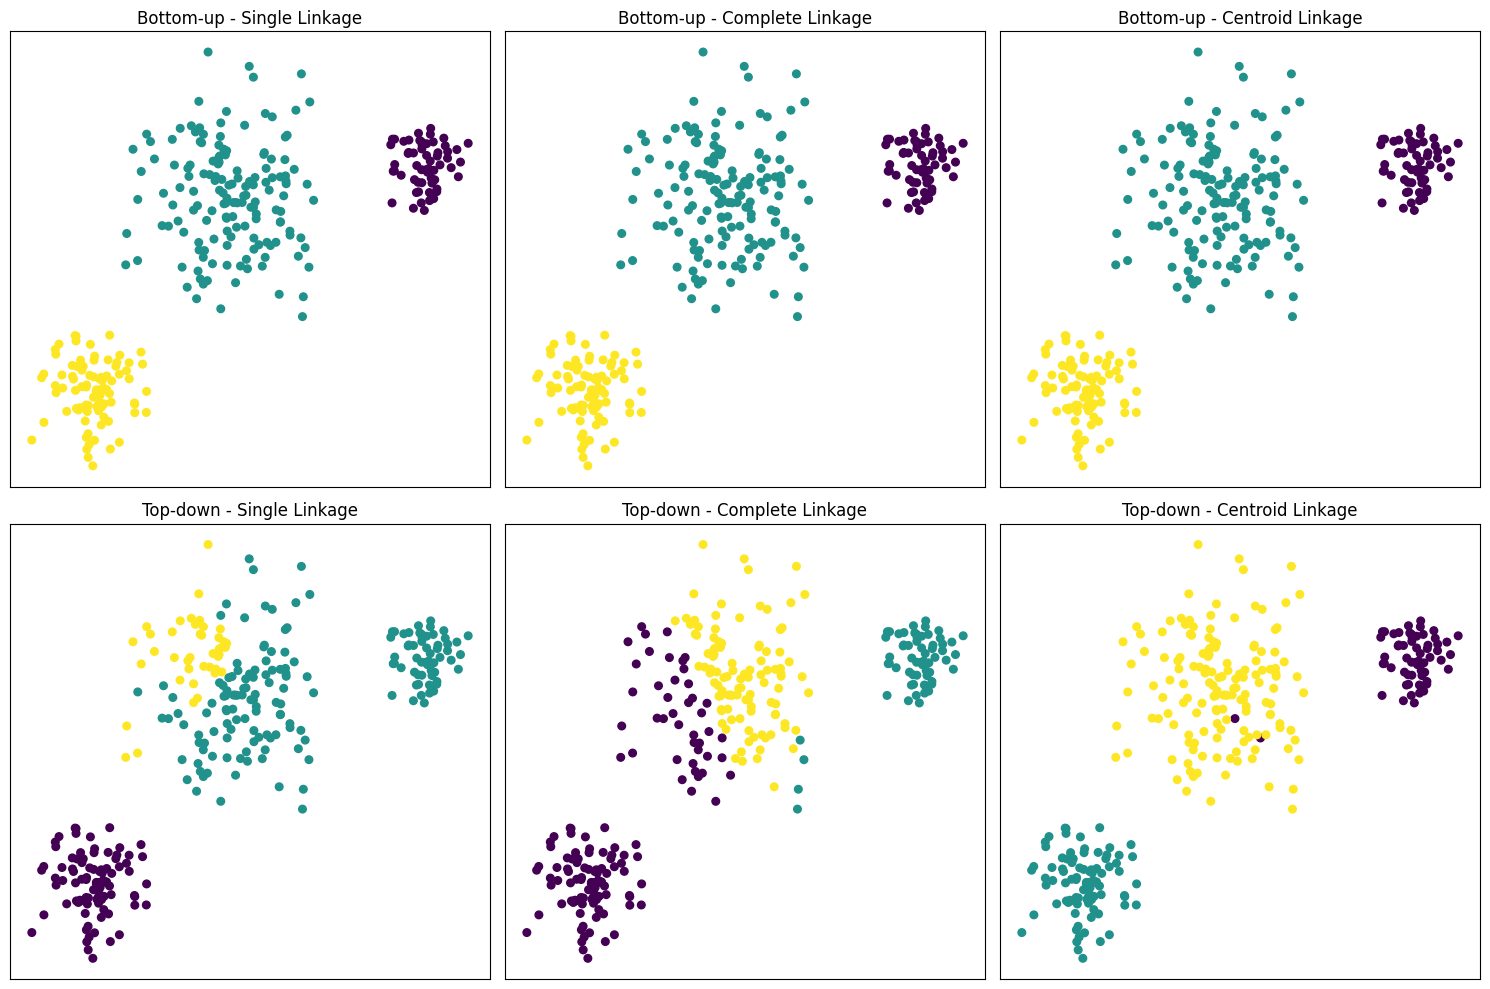

In [495]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
linkages = ['single', 'complete', 'centroid']
directions = ['bottom-up', 'top-down']
titles = ["Single Linkage", "Complete Linkage", "Centroid Linkage"]

for i, linkage in enumerate(linkages):
    for j, direction in enumerate(directions):
        labels = hierarchical_clustering(dataset_small, n_clusters=3, direction=direction, linkage=linkage)
        ax = axes[j, i]
        ax.scatter(dataset_small[:, 0], dataset_small[:, 1], c=labels, s=30, cmap='viridis')
        ax.set_title(f"{direction.capitalize()} - {titles[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

#### **Kmeans**

- $K$ 均值聚类的目标：

  找到一个最优划分 $\mathcal{C}*$——类内距离足够小而类间距离足够大。
- 在 $K$ 均值聚类方法中，通常采用平方欧式距离来表示点与点之间的距离，即
  $$
    \| x_k - x_l \|_2^2 = \sum_{j=1}^{p} (x_{kj} - x_{lj})^2
   $$
- 由此，我们可以定义一个合理的损失函数数，即
  $$
  L(C) = \sum_{k=1}^{K} \sum_{i \in C_k} \| x_i - m_k \|_2^2
  $$
  
  其中，
  - $m_k$ 表示第 $k$ 类中所有样本的均值；
  - 这里 $n_k$ 是第 $k$ 类中样本的个数；
  
- 而 $K$ 均值聚类实际上就是解决一个最优化问题
  $$
  C^* = \arg \min_{C} L(C)
  $$
- 通常采用迭代法来求解 $K$ 均值聚类的问题，每次迭代包括两个步骤：
  - 确定 $K$ 个类的中心 $m_k$，将样本逐一分配到其最近的中心所对应的类中，得到一个聚类结果；
  - 更新每个类的样本均值，作为类的更新后的中心；重复此过程，直到收敛为止。
  - 收敛条件通常可以设置为**聚类结果不变**

编写 Kmeans 函数： 

In [501]:
def kmeans(data, n_clusters, max_iters=100):
    # 随机选择初始质心（索引）
    centroids = data[np.random.choice(len(data), n_clusters, replace=False)]
    
    for _ in range(max_iters):
        # 计算每个点到各个质心的距离，并分配到最近的质心
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2) # (n_samples, n_clusters)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return labels

对数据集进行 Kmeans 聚类并可视化聚类结果：

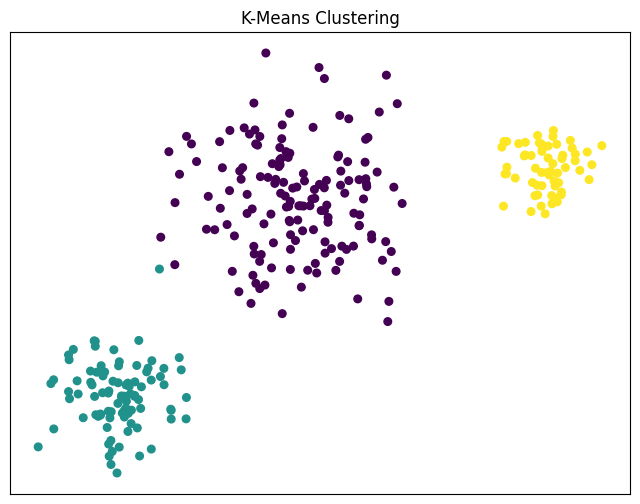

In [506]:
labels = kmeans(dataset_small,n_clusters=3)

plt.figure(figsize=(8, 6))
plt.scatter(dataset_small[:, 0], dataset_small[:, 1], c=labels, s=30, cmap='viridis')
plt.title("K-Means Clustering")
plt.xticks([])
plt.yticks([])
plt.show()

#### **GMM**

**核心**：假定来自一个类的样本均服从同一个正态分布。
- 对于第 $k$ 个正态分布 $N_p(\mu_k, \Sigma_k)$，$k = 1, 2, \cdots, K$：
  - $\mu_k$ 表示均值向量；
  - $\Sigma_k$ 表示协方差矩阵；
- 如果样本 $x_i$ 来自于第 $k$ 类，那么 $x_i$ 的密度函数为

    $$
    f(x_i) = (2\pi)^{-p/2} |\Sigma_k|^{-1/2} \exp \left\{ -\frac{1}{2} (x_i - \mu_k)' \Sigma_k^{-1} (x_i - \mu_k) \right\}, \quad i = 1, 2, \cdots, n.
    $$

- 如果我们知道第 $i$ 个样本是来自于第 $k$ 个高斯分布总体时，那么我们可以构造变量

  $$
  \delta_{ik} = 
  \begin{cases}
  1, & \text{当第 } i \text{ 个样本 } x_i \text{ 属于第 } k \text{ 个总体；} \\
  0, & \text{当第 } i \text{ 个样本 } x_i \text{ 不属于第 } k \text{ 个总体。}
  \end{cases}
  $$

- 于是，$\delta_i = (\delta_{i1}, \delta_{i2}, \cdots, \delta_{iK})'$ 满足
  - 独立同分布的随机向量；
  - 服从多项分布 $M(1, \pi_1, \pi_2, \cdots, \pi_K)$
  - $\pi_k = P(\delta_{ik} = 1)$ 且满足
    $$
    0<\pi_k<1,\quad \sum\limits_{i=1}^K\pi_k=1
    $$

- $\delta_i = (\delta_{i1}, \delta_{i2}, \cdots, \delta_{iK})'$ 的密度函数为

    $$
    f(\delta_i) = \prod_{k=1}^K (\pi_k)^{\delta_{ik}}, \quad i = 1, 2, \cdots, n
    $$

**估计方法：EM 算法**
- 高斯混合模型中的 EM 算法本质上也是迭代算法，每次迭代包括两个步骤：

  - 计算个体的类别概率期望，即
    $$
    \pi_{ik}^* = \frac{\pi_k \phi(x_i; \mu_k, \Sigma_k)}{\sum_{k=1}^K \pi_k \phi(x_i; \mu_k, \Sigma_k)}.
    $$

  - 更新参数 $\{\mu_k, \Sigma_k, \pi_k\}_{k=1}^K$，即
    $$
    \mu_k = \frac{\sum_{i=1}^n \pi_{ik}^* x_i}{\sum_{i=1}^n \pi_{ik}^*},
    $$
    $$
    \Sigma_k = \frac{\sum_{i=1}^n \pi_{ik}^* (x_i - \mu_k)(x_i - \mu_k)'}{\sum_{i=1}^n \pi_{ik}^*},
    $$
    $$
    \pi_k = n^{-1} \sum_{i=1}^n \pi_{ik}^*.
    $$


编写计算多元高斯分布的概率密度函数的代码：

- 对于一个 $ p $ 维的数据点 $ x $，多元高斯分布的概率密度函数定义为：
    $$
    f(x) = \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
    $$

In [ ]:
def gaussian(x, mean, cov):
    size = len(x)
    cov += np.eye(size) * 1e-6 # 避免行列式为零
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (pow((2 * math.pi), float(size) / 2) * math.sqrt(det_cov))   # 归一化常数，保证概率密度的积分为1
    x_mu = np.matrix(x - mean)
    inv_cov = np.linalg.inv(cov)
    result = norm_const * np.exp(-0.5 * (x_mu * inv_cov * x_mu.T))
    return float(result)

编写 GMM 的函数：

In [517]:
def gmm(data, n_clusters, max_iters=100):
    n_samples = data.shape[0]
    weights = np.ones(n_clusters) / n_clusters  # 均匀初始化每个簇的初始权重(二维)
    means = data[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.cov(data, rowvar=False) for _ in range(n_clusters)]   # 每个簇的协方差矩阵，初始为数据的整体协方差(2x2)
    
    for _ in range(max_iters):
        # E-step: 计算响应度
        responsibilities = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            for i in range(n_samples):
                responsibilities[i, k] = weights[k] * gaussian(data[i], means[k], covariances[k])
        # 对每一行进行归一化处理，使得每个数据点在所有簇上的概率之和等于1
        responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)

        # M-step: 更新参数
        Nk = responsibilities.sum(axis=0)
        for k in range(n_clusters):
            means[k] = (1 / Nk[k]) * np.sum(responsibilities[:, k][:, np.newaxis] * data, axis=0)
            covariances[k] = (1 / Nk[k]) * np.dot((responsibilities[:, k][:, np.newaxis] * (data - means[k])).T, (data - means[k]))
            weights[k] = Nk[k] / n_samples
    
    labels = np.argmax(responsibilities, axis=1)
    return labels

对数据集进行 GMM 聚类并可视化聚类结果：

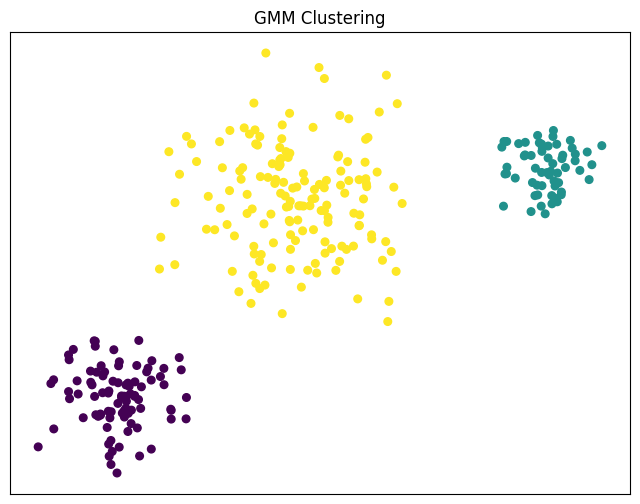

In [518]:
labels = gmm(dataset_small,n_clusters=3)

plt.figure(figsize=(8, 6))
plt.scatter(dataset_small[:, 0], dataset_small[:, 1], c=labels, s=30, cmap='viridis')
plt.title("GMM Clustering")
plt.xticks([])
plt.yticks([])
plt.show()

#### **DBSCAN**

这是是一种典型的基于密度的聚类方法，它主要思想为：如果要判断两个样本属于同一类别，那么在这两个样本的附近，能够找到属于同一类别的样本。
- 数据集 $X = \{ x_1, x_2, \cdots, x_n \}^{\prime}, \; x_i = (x_{i1}, x_{i2}, \cdots, x_{ip})^{\prime}$；
- 每个样本 $x_i$ 可以看作 $R^p$ 空间中的一个点；
- 假定第 $k$ 个点 $x_k$ 和第 $l$ 个点 $x_l$ 之间的距离为 $d(k, l)$。
- 给定邻域半径 $\epsilon > 0$ 和可到达的最少样本个数 $\text{MinPts}$，
  - 如果
    $$N_{\epsilon}(k) = \{ x_l \in X | d(k, l) \leq \epsilon \},$$
    那么，称点 $x_k$ 的 $\epsilon$ 邻域；
  - 如果
    $$|N_{\epsilon}(k)| \geq \text{MinPts},$$
    那么，称点 $x_k$ 为核心点。


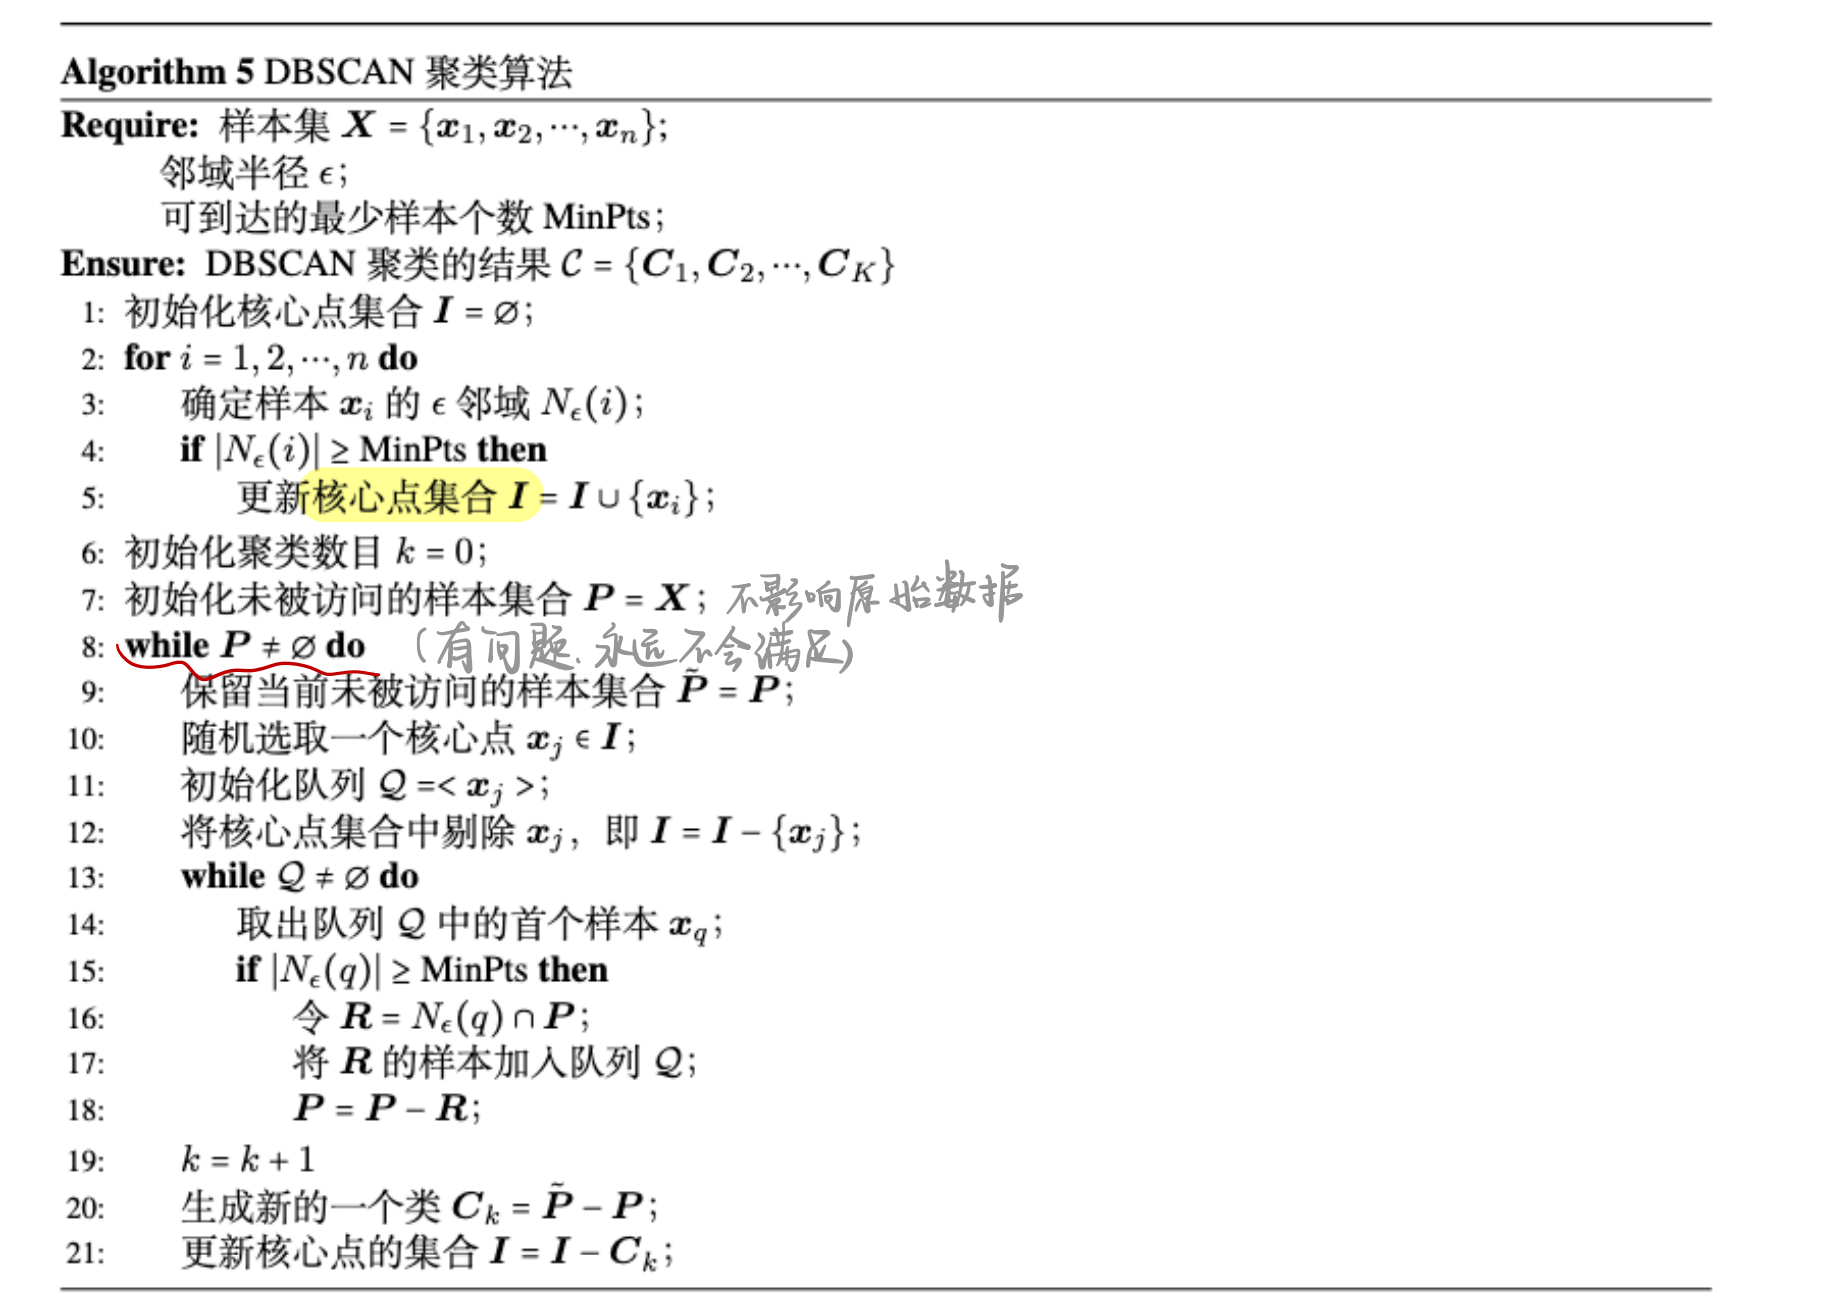

编写 DBSCAN 函数的代码：

In [ ]:
def dbscan(data, eps, min_samples):
    n_samples = len(data)
    labels = np.full(n_samples, -1)  # 初始化所有点为噪声点
    cluster_id = 0
    
    # 查找点的邻域
    def region_query(point_idx):
        return [i for i in range(n_samples) if np.linalg.norm(data[point_idx] - data[i]) < eps]
    
    for i in range(n_samples):
        if labels[i] != -1:
            continue
        
        neighbors = region_query(i)
        if len(neighbors) < min_samples:    # 邻域中的点少于 min_samples，该点被标记为噪声点
            labels[i] = -1
        else:                               # 如果是核心点，开始一个新簇
            labels[i] = cluster_id
            queue = deque(neighbors)
            while queue:
                neighbor_idx = queue.popleft()
                if labels[neighbor_idx] == -1:  # 如果当前点是噪声点
                    labels[neighbor_idx] = cluster_id
                if labels[neighbor_idx] != -1:  # 如果已访问
                    continue
                new_neighbors = region_query(neighbor_idx)
                if len(new_neighbors) >= min_samples:
                    queue.extend(new_neighbors)
            cluster_id += 1  # 增加簇的标识

    return labels

对数据集进行 DBSCAN 聚类并可视化聚类结果：

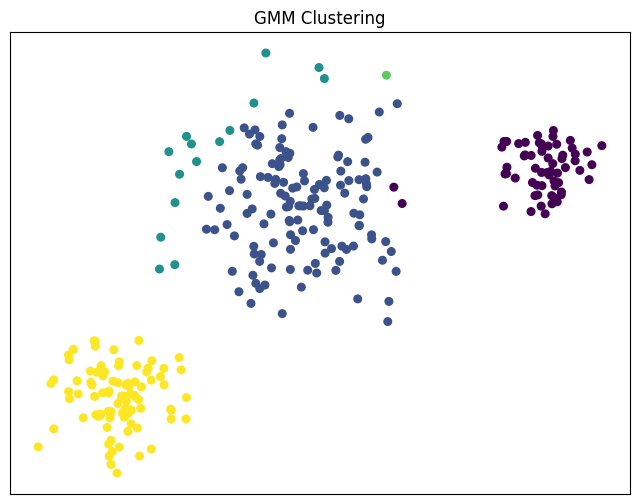

In [581]:
labels = dbscan(dataset_small,0.9,10)

plt.figure(figsize=(8, 6))
plt.scatter(dataset_small[:, 0], dataset_small[:, 1], c=labels, s=30, cmap='viridis')
plt.title("GMM Clustering")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
for i in range                  